In [1]:
import wandb
wandb.login(key = "eb9574fa5b11da36782604ea27df8bf1989ddefd")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: megh_m (megh_m-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.3 MB/s eta 0:00:0000:0100:01


In [3]:
import os
os.environ["WANDB_SILENT"] = "false"
os.environ["WANDB_START_METHOD"] = "thread"
os.environ["WANDB_API_KEY"] = "eb9574fa5b11da36782604ea27df8bf1989ddefd"

In [4]:
import numpy as np
import torch
import torch.nn as nn
import random
import torch.nn.functional as F

# Utils

In [5]:
class CharEmbed(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(CharEmbed, self).__init__()
        self.embed = nn.Embedding(input_dim, embed_dim)
    
    def forward(self, input_seq):
        return self.embed(input_seq)

class EncoderRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, n_layers=1, 
                 cell_type='GRU', dropout=0.0, bidirectional=False):
        super(EncoderRNN, self).__init__()
        self.embed = nn.Embedding(input_dim, embed_dim)
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.cell_type = cell_type
        self.bidirectional = bidirectional #to allow forward and backward time step data processing
        # Cell type options GRU, LSTM & vanilla RNN
        if cell_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, bidirectional=bidirectional)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, bidirectional=bidirectional)
        else: 
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, bidirectional=bidirectional)
    
    def forward(self, input_seq, input_lengths, hidden=None):
        # Sort sequences by length
        input_lengths, sort_idx = torch.sort(input_lengths, descending=True)
        input_seq = input_seq[:, sort_idx]  # (seq_len, batch_size, ...)
        
        # Convert to embeddings
        embedded = self.embed(input_seq)
        
        # Pack with enforce_sorted=False
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, 
            input_lengths.cpu(), 
            enforce_sorted=False
        )
        
        # Forward pass
        outputs, hidden = self.rnn(packed, hidden)
        
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        
        # Restore original order
        _, unsort_idx = torch.sort(sort_idx)
        outputs = outputs[:, unsort_idx]
        
        # Handle LSTM hidden/cell states
        if isinstance(hidden, tuple):
            hidden = (
                hidden[0][:, unsort_idx],  # Hidden state
                hidden[1][:, unsort_idx]   # Cell state
            )
        else:  # For GRU/RNN
            hidden = hidden[:, unsort_idx]
        
        return outputs, hidden

class DecoderRNN(nn.Module): #Basically similar to the encoder, will have a softmax to predict next char
    def __init__(self, output_dim, embed_dim, hidden_dim, vocab, n_layers=1, cell_type='GRU', dropout=0.0, go_idx=1, stop_idx=2):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(output_dim, embed_dim)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.cell_type = cell_type
        self.go_idx = go_idx
        self.stop_idx = stop_idx
        self.vocab = vocab
        if cell_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0)
        else:
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0)
        
        self.out = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        # Get embedding of current input character
        embedded = self.embed(input).unsqueeze(0)
        
        # Forward pass through decoder
        output, hidden = self.rnn(embedded, hidden)
        
        # Predict next character probabilities
        output = self.softmax(self.out(output.squeeze(0)))
        
        return output, hidden


In [26]:
class Seq2Seq(nn.Module): #Flexible enough to use different encoders other than the ones we define
    def __init__(self, input_dim, output_dim, embed_dim, hidden_dim, num_layers, cell_type, dropout, device,vocab, go_idx=1, stop_idx=2):
        #super().__init__()
        super(Seq2Seq, self).__init__()
        self.device = device
        self.go_idx = go_idx
        self.stop_idx = stop_idx
        self.vocab = vocab
            # Internal encoder creation
        self.encoder = EncoderRNN(
            input_dim=input_dim,
            embed_dim=embed_dim,
            hidden_dim=hidden_dim,
            n_layers=num_layers,
            cell_type=cell_type,
            dropout=dropout
        )
        
        # Internal decoder creation
        self.decoder = DecoderRNN(
            output_dim=output_dim,
            embed_dim=embed_dim,
            hidden_dim=hidden_dim,
            n_layers=num_layers,
            cell_type=cell_type,
            dropout=dropout,
            vocab = vocab,
            go_idx = go_idx,
            stop_idx = stop_idx
        )
        self.device = device 
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # Last hidden state of the encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        
        # First input to the decoder is the <go> token
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            
            # To Decide if we're going to use teacher forcing or not as needed
            teacher_force = random.random() < teacher_forcing_ratio
            
            # Get the highest predicted token from our predictions
            top1 = output.argmax(1)
            
            # If we use teacher forcing, we have to use actual next token as next input
            # If not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs
        
    def beam_search(self, src, src_len, beam_width=5, max_len=50):
        """Batch-friendly beam search implementation"""
        self.eval()
        batch_size = src.size(1)
        
        # Initialize beams with GO token
        beams = torch.full((batch_size * beam_width, max_len), 
                          self.decoder.stop_idx, 
                          device=self.device)
        beams[:, 0] = self.decoder.go_idx
        beam_scores = torch.zeros(batch_size * beam_width, device=self.device)
        
        # Encode source sequence
        encoder_outputs, hidden = self.encoder(src, src_len)
        
        # Expand hidden states
        if isinstance(hidden, tuple):  # LSTM
            hidden = (
                hidden[0].repeat(1, beam_width, 1),
                hidden[1].repeat(1, beam_width, 1)
            )
        else:  # GRU/RNN
            hidden = hidden.repeat(1, beam_width, 1)
        
        for step in range(max_len-1):
            decoder_input = beams[:, step]
            output, hidden = self.decoder.forward(decoder_input, hidden)
            
            log_probs = F.log_softmax(output, dim=1)
            topk_log_probs, topk_indices = torch.topk(log_probs, beam_width, dim=1)
            
            # Reshape scores
            if step == 0:
                # First step: (batch, beam) -> (batch, beam*beam)
                expanded_scores = topk_log_probs.view(batch_size, -1)
            else:
                # Subsequent steps: (batch, beam, beam) -> (batch, beam*beam)
                expanded_scores = beam_scores.view(batch_size, beam_width, 1) + \
                                 topk_log_probs.view(batch_size, beam_width, beam_width)
                expanded_scores = expanded_scores.view(batch_size, -1)
            
            # Select top candidates
            top_scores, top_indices = torch.topk(expanded_scores, beam_width, dim=1)
            
            # Calculate beam/token origins
            beam_indices = top_indices // beam_width
            token_indices = top_indices % beam_width
            
            # Update beams with CORRECT indices
            beams = beams.view(batch_size, beam_width, -1)
            beams = torch.cat([
                beams[torch.arange(batch_size)[:, None], beam_indices],
                token_indices.unsqueeze(-1)  # Correct index usage
            ], dim=-1)
            beams = beams.view(batch_size * beam_width, -1)
            
            # Update scores and hidden states
            beam_scores = top_scores.view(-1)
            if isinstance(hidden, tuple):
                hidden = (
                    hidden[0][:, beam_indices.view(-1), :].contiguous(),
                    hidden[1][:, beam_indices.view(-1), :].contiguous()
                )
            else:
                hidden = hidden[:, beam_indices.view(-1), :].contiguous()
            
            # Early stopping check
            current_tokens = beams[:, step+1]
            if (current_tokens == self.decoder.stop_idx).all():
                break
    
        return self._process_beams(beams.view(batch_size, beam_width, -1))

    def _process_beams(self, beams_tensor):
        """
        Converts beam search output tensor into cleaned token sequences.
        
        Args:
            beams_tensor: Tensor of shape (batch_size, beam_width, max_len)
            
        Returns:
            List[List[List[str]]]: For each batch item, a list of beam sequences.
        """
        batch_size, beam_width, max_len = beams_tensor.size()
        processed_beams = []
        
        for batch_idx in range(batch_size):
            batch_sequences = []
            for beam_idx in range(beam_width):
                # Extract token indices for this beam
                indices = beams_tensor[batch_idx, beam_idx].tolist()
                
                # Remove <go> (go_idx) at the start if present
                if indices[0] == self.decoder.go_idx:
                    indices = indices[1:]  # Remove first element
                
                # Truncate at first <stop> (stop_idx)
                try:
                    stop_pos = indices.index(self.decoder.stop_idx)
                    indices = indices[:stop_pos]  # Exclude <stop>
                except ValueError:
                    pass  # No <stop> found, use all tokens
                
                # Remove padding (assuming pad_idx = 0)
                cleaned_indices = [idx for idx in indices if idx not in [0, self.decoder.go_idx, self.decoder.stop_idx, 3]]
                
                # Convert indices to tokens
                tokens = [self.decoder.vocab.idx2char[idx] for idx in cleaned_indices]
                batch_sequences.append(tokens)
            
            processed_beams.append(batch_sequences)
        
        return processed_beams



# Dataset Loading & Preprocessing

In [88]:
import os
import tarfile
import requests
import pandas as pd
from io import BytesIO
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import wandb

# Dataset Configuration
DATASET_URL = "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"
DATA_DIR = "./dakshina_dataset"
HI_LEXICON_DIR = os.path.join(DATA_DIR,"dakshina_dataset_v1.0", "hi", "lexicons") #For Hindi (Chosen Language)

def download_and_extract_dataset(): #Scripted Dataset Download
    if not os.path.exists(DATA_DIR):
        print("Downloading dataset...")
        response = requests.get(DATASET_URL)
        file = tarfile.open(fileobj=BytesIO(response.content))
        file.extractall(DATA_DIR)
        print("Dataset extracted successfully")

class TransliterationVocabulary: #Build Character Vocab and add go,stop, padding and unknown tokens
    def __init__(self):
        self.char2idx = defaultdict(lambda: len(self.char2idx))
        self.idx2char = {}
        self.special_tokens = ['<pad>', '<go>', '<stop>', '<unk>']
        
        # Initialize special tokens
        for token in self.special_tokens:
            self.char2idx[token]
        
        self.idx2char = {v: k for k, v in self.char2idx.items()}
    
    def add_word(self, word):
        #print(word) #for debugging
        for char in word:
            self.char2idx[char]
        self.idx2char = {v: k for k, v in self.char2idx.items()}

class TransliterationDataset(Dataset): #Dataset loader for Hindi
    def __init__(self, split='train'):
        self.split = split
        self.data = self._load_data()
        self.src_vocab = TransliterationVocabulary()
        self.trg_vocab = TransliterationVocabulary()
        
        # Build vocabularies
        for src,trg in self.data:
            self.src_vocab.add_word(src)
            self.trg_vocab.add_word(trg)
    
    def _load_data(self):
        """Load data from TSV files and filter non-string entries"""
        file_map = {
            'train': 'hi.translit.sampled.train.tsv',
            'dev': 'hi.translit.sampled.dev.tsv',
            'test': 'hi.translit.sampled.test.tsv'
        }
        
        df = pd.read_csv(
            os.path.join(HI_LEXICON_DIR, file_map[self.split]),
            sep='\t', 
            header=None,
            names=['devanagari', 'latin', 'count'],
            dtype={'latin': str, 'devanagari': str, 'count':int}  # Force string type
        )
        
        # Filter out non-string entries and empty strings
        valid_entries = [
            (latin, devanagari) 
            for latin, devanagari in zip(df['latin'], df['devanagari'])
            if (isinstance(latin, str) and 
                isinstance(devanagari, str) and
                len(latin) > 0 and 
                len(devanagari) > 0)
        ]
        
        return valid_entries

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        src, trg = self.data[idx]
        return (
            [self.src_vocab.char2idx['<go>']] + 
            [self.src_vocab.char2idx[c] for c in src if c not in ['<go>','<stop>','<pad>','<unk>']] +
            [self.src_vocab.char2idx['<stop>']],
            [self.trg_vocab.char2idx['<go>']] + 
            [self.trg_vocab.char2idx[c] for c in trg if c not in ['<go>','<stop>','<pad>','<unk>']] +
            [self.trg_vocab.char2idx['<stop>']]
        )

def collate_fn(batch): #Padding and Masking
    src_batch, trg_batch = zip(*batch)
    
    src_lens = torch.tensor([len(x) for x in src_batch])
    trg_lens = torch.tensor([len(x) for x in trg_batch])
    
    src_pad = pad_sequence(
        [torch.tensor(x) for x in src_batch],
        padding_value=0  # <pad> token index
    )
    
    trg_pad = pad_sequence(
        [torch.tensor(x) for x in trg_batch],
        padding_value=0  # <pad> token index
    )
    
    return src_pad, trg_pad, src_lens, trg_lens

def get_dataloaders(batch_size=64):
    """Create train, dev, test dataloaders"""
    download_and_extract_dataset()
    
    train_dataset = TransliterationDataset('train')
    dev_dataset = TransliterationDataset('dev')
    test_dataset = TransliterationDataset('test')
    
    return (
        DataLoader(train_dataset, batch_size=batch_size, 
                  shuffle=True, collate_fn=collate_fn),
        DataLoader(dev_dataset, batch_size=batch_size, 
                 collate_fn=collate_fn),
        DataLoader(test_dataset, batch_size=batch_size,
                 collate_fn=collate_fn),
        train_dataset.src_vocab,
        train_dataset.trg_vocab
    )


In [ ]:

df = pd.read_csv(
            os.path.join(HI_LEXICON_DIR,'hi.translit.sampled.train.tsv'),
            sep='\s+',  #specifying seperator
            header=None,
            names=['devanagari','latin','syllables']
        )
list(zip(df['latin'], df['devanagari']))
# Filter out non-string entries and empty strings
valid_entries = [
    (latin, devanagari) 
    for latin, devanagari in zip(df['latin'], df['devanagari'])
    if (isinstance(latin, str) and 
        isinstance(devanagari, str) and
        len(latin) > 0 and 
        len(devanagari) > 0)
]

#return valid_entries
print(valid_entries)

In [9]:
import torch
from jiwer import cer, wer
from jiwer import visualize_alignment

class TransliterationMetrics:
    @staticmethod
    def preprocess_sequence(indices, vocab, remove_special=True):
        """Convert index tensor to cleaned character sequence"""
        chars = []
        for idx in indices:
            char = vocab.idx2char[idx]
            if remove_special and char in ['<go>', '<stop>', '<pad>','<unk>']:
                continue
            chars.append(char)
        return ''.join(chars)

def evaluate_cer(model, loader, device, beam_width=5):
    """Calculate Character Error Rate"""
    model.eval()
    total_cer = 0.0
    total = 0
    
    with torch.no_grad():
        for src, trg, src_lens, trg_lens in loader:
            src = src.to(device)
            
            # Get beam search predictions
            beam_outputs = model.beam_search(src, src_lens, beam_width)
            
            # Process batch
            for i in range(src.size(1)):
                # Get target sequence
                target_indices = trg[1:trg_lens[i]-1, i].cpu().tolist()
                target_str = TransliterationMetrics.preprocess_sequence(target_indices, model.decoder.vocab)
                
                # Get top prediction
                pred_indices = beam_outputs[i][0]
                pred_str = TransliterationMetrics.preprocess_sequence(pred_indices, model.decoder.vocab)
                
                # Calculate CER
                if target_str:  # Handle empty targets
                    total_cer += cer(target_str, pred_str)
                    total += 1
                else:
                    total_cer += 1.0  # Penalize completely wrong predictions
                    total += 1
                
    return total_cer / total if total > 0 else 0

def evaluate_wer(model, loader, device, beam_width=5):
    """Calculate Word Error Rate (for reference)"""
    model.eval()
    total_wer = 0.0
    total = 0
    
    with torch.no_grad():
        for src, trg, src_lens, trg_lens in loader:
            src = src.to(device)
            
            beam_outputs = model.beam_search(src, src_lens, beam_width)
            
            for i in range(src.size(1)):
                target_indices = trg[1:trg_lens[i]-1, i].cpu().tolist()
                target_str = TransliterationMetrics.preprocess_sequence(target_indices, model.decoder.vocab)
                
                pred_indices = beam_outputs[i][0]
                pred_str = TransliterationMetrics.preprocess_sequence(pred_indices, model.decoder.vocab)
                
                if target_str:
                    total_wer += wer(target_str, pred_str)
                    total += 1
                else:
                    total_wer += 1.0
                    total += 1
                
    return total_wer / total if total > 0 else 0

# Train Sweep

In [29]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_char_err', 'goal': 'minimize'},
    'parameters': {
        'embedding_size': {'values': [64, 128, 256]},
        'hidden_size': {'values': [128, 256, 512]},
        'num_layers': {'values': [1, 2, 3]},
        'cell_type': {'values': ['LSTM', 'GRU', 'RNN']},
        'dropout': {'values': [0.2, 0.3]},
        'learning_rate': {'values': [0.001, 0.0005, 0.0001]},
        'batch_size': {'values': [32, 64, 128]},
    }
}

In [32]:
def train(config=None):
    with wandb.init(project="DA6401_A3",settings=wandb.Settings(start_method="thread",_disable_stats=True), config = config) as run:
        config = run.config
        
        # Get dataloaders and vocabularies
        train_loader, dev_loader, _, src_vocab, trg_vocab = get_dataloaders(
            batch_size=config.batch_size
        )
        go_idx = trg_vocab.char2idx['<go>']
        stop_idx = trg_vocab.char2idx['stop']
        # Initialize model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model = Seq2Seq(
            input_dim=len(src_vocab.char2idx),
            output_dim=len(trg_vocab.char2idx),
            embed_dim=config.embedding_size,
            hidden_dim=config.hidden_size,
            num_layers=config.num_layers,
            cell_type=config.cell_type,
            dropout=config.dropout,
            device=device,
            go_idx = go_idx,
            stop_idx = stop_idx,
            vocab = trg_vocab
        ).to(device)
        
        # Training setup
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
        
        # Training loop
        for epoch in range(15):  # Fixed epoch count for sweep
            model.train()
            total_loss = 0
            
            for src, trg, src_lens, trg_lens in train_loader:
                src = src.to(device)
                trg = trg.to(device)
                
                optimizer.zero_grad()
                output = model(src, src_lens, trg)
                
                # Calculate loss
                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)
                
                loss = criterion(output, trg)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()
                
                total_loss += loss.item()
            file_path = os.path.join(wandb.run.dir, "model.pth")
            torch.save(model.state_dict(), file_path)
            wandb.save('model.pth')
            # Validation
            #val_cer = evaluate_cer(model, dev_loader, device)
            #val_wer = evaluate_wer(model, dev_loader, device)
            val_acc = evaluate(model, dev_loader, device)
            wandb.log({
                'epoch': epoch,
                'train_loss': total_loss/len(train_loader),
                'val_acc': val_acc
            })

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for src, trg, src_lens, trg_lens in loader:
            src = src.to(device)
            trg = trg.to(device)
            
            outputs = model(src, src_lens, trg, 0)  # No teacher forcing
            outputs = outputs.argmax(dim=-1)
            
            # Calculate accuracy
            mask = (trg != 0)
            correct += ((outputs == trg) * mask).sum().item()
            total += mask.sum().item()
    
    return correct / total

In [33]:
def train_with_beam(config=None):
    with wandb.init(project="DA6401_A3",settings=wandb.Settings(start_method="thread",_disable_stats=True), config = config) as run:
        config = run.config
        
        # Get dataloaders and vocabularies
        train_loader, dev_loader, _, src_vocab, trg_vocab = get_dataloaders(
            batch_size=config.batch_size
        )
        go_idx = trg_vocab.char2idx['<go>']
        stop_idx = trg_vocab.char2idx['stop']
        # Initialize model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model = Seq2Seq(
            input_dim=len(src_vocab.char2idx),
            output_dim=len(trg_vocab.char2idx),
            embed_dim=config.embedding_size,
            hidden_dim=config.hidden_size,
            num_layers=config.num_layers,
            cell_type=config.cell_type,
            dropout=config.dropout,
            device=device,
            go_idx = go_idx,
            stop_idx = stop_idx,
            vocab = trg_vocab
        ).to(device)
        
        # Training setup
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
        
        # Training loop
        for epoch in range(15):  # Fixed epoch count for sweep
            model.train()
            total_loss = 0
            
            for src, trg, src_lens, trg_lens in train_loader:
                src = src.to(device)
                trg = trg.to(device)
                
                optimizer.zero_grad()
                output = model(src, src_lens, trg)
                
                # Calculate loss
                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)
                
                loss = criterion(output, trg)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()
                
                total_loss += loss.item()
            file_path = os.path.join(wandb.run.dir, "model.pth")
            torch.save(model.state_dict(), file_path)
            wandb.save('model.pth')
            # Validation
            #val_cer = evaluate_cer(model, dev_loader, device)
            #val_wer = evaluate_wer(model, dev_loader, device)
            val_acc = evaluate(model, dev_loader, device)
            wandb.log({
                'epoch': epoch,
                'train_loss': total_loss/len(train_loader),
                #'val_char_err': val_cer,
                #'val_word_err': val_wer
                'val_acc':val_acc
            })

In [85]:
train_loader, dev_loader, test_loader, src_vocab, trg_vocab = get_dataloaders()
print(f"Source vocab size: {len(src_vocab.char2idx)}")
print(f"Target vocab size: {len(trg_vocab.char2idx)}")
print(f"Training batches: {len(train_loader)}")

Source vocab size: 30
Target vocab size: 67
Training batches: 691


In [16]:
#TransliterationDataset('test').data[2][1]

In [17]:
src_vocab.char2idx

defaultdict(<function __main__.TransliterationVocabulary.__init__.<locals>.<lambda>()>,
            {'<pad>': 0,
             '<go>': 1,
             '<stop>': 2,
             '<unk>': 3,
             'a': 4,
             'n': 5,
             'k': 6,
             'g': 7,
             'i': 8,
             't': 9,
             'u': 10,
             'c': 11,
             'l': 12,
             'e': 13,
             'r': 14,
             's': 15,
             'h': 16,
             'd': 17,
             'b': 18,
             'y': 19,
             'o': 20,
             'j': 21,
             'z': 22,
             'm': 23,
             'v': 24,
             'w': 25,
             'p': 26,
             'f': 27,
             'x': 28,
             'q': 29})

In [18]:
#src_vocab.idx2char

In [66]:
trg_vocab.char2idx

defaultdict(<function __main__.TransliterationVocabulary.__init__.<locals>.<lambda>()>,
            {'<pad>': 0,
             '<go>': 1,
             '<stop>': 2,
             '<unk>': 3,
             'अ': 4,
             'ं': 5,
             'क': 6,
             'ग': 7,
             'ण': 8,
             'ि': 9,
             'त': 10,
             'ल': 11,
             'ु': 12,
             'र': 13,
             'श': 14,
             'द': 15,
             'न': 16,
             'े': 17,
             'भ': 18,
             '्': 19,
             'ष': 20,
             'ा': 21,
             'ी': 22,
             'ठ': 23,
             'य': 24,
             'ो': 25,
             'ू': 26,
             'ज': 27,
             'च': 28,
             'म': 29,
             'ट': 30,
             'ड': 31,
             'व': 32,
             'ः': 33,
             'ह': 34,
             'प': 35,
             'ृ': 36,
             'स': 37,
             'ध': 38,
             'ै': 39,
             '़': 40,
    

In [19]:
# Initialize sweep
sweep_id = wandb.sweep(
    sweep=sweep_config,  # Your sweep configuration dictionary
    project="DA6401_A3",
    entity="megh_m-iit-madras"
)

# Run sweep agents
wandb.agent(sweep_id, function=train_with_beam, count = 10)

'# Initialize sweep\nsweep_id = wandb.sweep(\n    sweep=sweep_config,  # Your sweep configuration dictionary\n    project="DA6401_A3",\n    entity="megh_m-iit-madras"\n)\n\n# Run sweep agents\nwandb.agent(sweep_id, function=train, count = 10)'

In [20]:
def show_alignment_example(model, sample):
    src, trg = sample
    pred = model.beam_search(src.unsqueeze(1), [len(src)], beam_width=1)[0][0]
    
    target_str = TransliterationMetrics.preprocess_sequence(trg[1:-1], model.decoder.vocab)
    pred_str = TransliterationMetrics.preprocess_sequence(pred, model.decoder.vocab)
    
    print("CER:", cer(target_str, pred_str))
    print("Target:", target_str)
    print("Predicted:", pred_str)
    visualize_alignment(target_str, pred_str)

In [67]:
for src, trg, src_lens, trg_lens in test_loader():
    print(trg)

TypeError: 'DataLoader' object is not callable

In [21]:
# For analysis
'''sample = next(iter(dev_loader))
show_alignment_example(model, sample[0][0], sample[1][0])'''

'sample = next(iter(dev_loader))\nshow_alignment_example(model, sample[0][0], sample[1][0])'

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = AttnSeq2Seq(
            input_dim=len(src_vocab.char2idx),
            output_dim=len(trg_vocab.char2idx)+1,
            embed_dim=256,
            hidden_dim=256,
            num_layers=2,
            cell_type='RNN',
            dropout=0.2,
            device=device,
            go_idx = trg_vocab.char2idx['<go>'],
            stop_idx = trg_vocab.char2idx['<stop>'],
            vocab = trg_vocab
        ).to(device)
best_model.load_state_dict(torch.load('/kaggle/input/attn_model_2/pytorch/default/1/attn_model.pth',  weights_only = True))
best_model.eval()
evaluate_attn(best_model, test_loader, device)

0.1424018501805054

In [ ]:
with torch.no_grad():
        for src, trg, src_lens, trg_lens in test_loader:
            src = src.to(device)
            trg = trg.to(device)
            
            outputs = best_model(src, src_lens, trg, 0)  # No teacher forcing
            #outputs = outputs.argmax(dim=-1)

outputs.size()

In [86]:
results = []
with torch.no_grad():
    for src, trg, src_lens, trg_lens in test_loader:
        src = src.to(device)
        
        # Forward pass through encoder
        encoder_outputs, hidden = best_model.encoder(src, src_lens)
        
        # Greedy decoding
        batch_size = src.size(1)
        decoder_input = torch.full((1, batch_size), best_model.decoder.go_idx, device=device, dtype=torch.long)
        
        predictions = torch.zeros(50, batch_size, device=device, dtype=torch.long)

        for t in range(50):
            decoder_output, hidden, attn_wts = best_model.decoder(decoder_input.squeeze(0), hidden, encoder_outputs)
            topi = decoder_output.argmax(1)
            predictions[t] = topi
            decoder_input = topi.unsqueeze(0)

        # Process batch
        for i in range(batch_size):
            # Get source sequence
            src_indices = src[:,i].cpu().numpy()
            src_str = ''.join([src_vocab.idx2char[idx] for idx in src_indices if idx not in [0,1,2,3]])
            
            # Get prediction
            pred_indices = predictions[:,i].cpu().numpy()
            pred_str = ''.join([trg_vocab.idx2char[idx] for idx in pred_indices if idx not in [0,1,2,3]])
            
            results.append({
                'Source': src_str,
                'Prediction': pred_str,
                'Target': ''.join([trg_vocab.idx2char[idx] for idx in trg[:,i].cpu().numpy() if idx not in [0,1,2,3]])
            })

pd.DataFrame(results)

,Source,Prediction,Target
0,ank,अंक,अंक
1,anka,अंका,अंक
2,ankgi,अंकगी,अंकगण
3,anaktn,अनक्तन,अंकिं
4,ankutn,अंकुटन,अंकिं
...,...,...,...
4497,utzbgnc,उट्जबग्ं,ैिजरचगंल
4498,utvuancayaab,उत्वुंसाय,ैिईंलुीुा
4499,utvuancayab,उत्वुंसायब,ैिईंलुीुा
4500,utvirv,उत्विर्व,ैिडरवूड


In [ ]:
src_vocab.char2idx['a']

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    for src, trg, src_lens, trg_lens in test_loader:
        src = src.to(device)
        trg = trg.to(device)
        for i in range(1):
            # Get source sequence
            src_indices = src[:,i].cpu().numpy()
            src_str = ''.join([src_vocab.idx2char[idx] for idx in src_indices if idx not in [0, 1, 2, 3]])
            print(src_str) 

ank
aiiuav
ayyaavg
azg
goj
tlbrl
rkaiiug
diuaoaiak
dzauana
rwalmr
tvaka
kayl
xasg
ktti
jzrlgv
car
cazaqgtn
juanblahatn
jughaig
juudoakal
eahdag
eaankaltn
edbag
epaltn
itnca
bdznr
ialaycane
ireaeg
balla
bgmwa
buaiana
nakvazgwtn
nad
nglyaabu
oanjuaanc
oalaaburrn
oaiuwaklah
ogbgwa
oalailttorl
olantn
fazia
ftni
yabaia
yanyg
ygccrvi
yanbacr
yuayutti
yuaglt
hawtlkaa
hancang
hdyalkodl
habr
waina
laae
lrria
ltwazv
zazkalia
zrikal
mrlvgtn
mgbwaawrgn
mrltngka
vulaytn
vulglah
vanviugia
valkalrgn
vawan
vugrzb
vrnbua
viltkrv
uahazamal
udooal


In [ ]:
src_str

In [24]:
src, trg = TransliterationDataset('test').data[2]
for c in src:
    print(c)

a
n
k
i
t


In [25]:
[src_vocab.char2idx['<go>']] + [src_vocab.char2idx[c] for c in src if c not in ['<go>','<stop>','<pad>','<unk>']] +[src_vocab.char2idx['<stop>']]


[1, 4, 5, 6, 8, 9, 2]

# With Attention

In [15]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        # Project encoder outputs to decoder's hidden space
        self.enc_proj = nn.Linear(enc_hidden_dim, dec_hidden_dim)
        # Project decoder hidden state
        self.dec_proj = nn.Linear(dec_hidden_dim, dec_hidden_dim)
        # Energy layer
        self.energy = nn.Linear(dec_hidden_dim, 1)
        
    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (1, batch_size, dec_hidden_dim)
        # encoder_outputs: (seq_len, batch_size, enc_hidden_dim)
        
        # Project both to same dimension
        dec_proj = self.dec_proj(decoder_hidden.squeeze(0))  # (batch_size, dec_hidden)
        enc_proj = self.enc_proj(encoder_outputs)  # (seq_len, batch_size, dec_hidden)
        
        # Expand and combine
        dec_proj = dec_proj.unsqueeze(1)  # (batch_size, 1, dec_hidden)
        enc_proj = enc_proj.permute(1, 0, 2)  # (batch_size, seq_len, dec_hidden)
        
        # Calculate scores
        scores = self.energy(torch.tanh(dec_proj + enc_proj))  # (batch_size, seq_len, 1)
        attn_weights = F.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.permute(0,2,1), enc_proj) 
        return context, attn_weights


In [16]:
class Attention2(nn.Module):
    def __init__(self, hidden_size):
        super(Attention2, self).__init__()
        self.encoder_proj = nn.Linear(hidden_size, hidden_size)
        self.decoder_proj = nn.Linear(hidden_size, hidden_size)
        self.energy = nn.Linear(hidden_size, 1)
        
    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (num_layers, batch_size, hidden_size)
        # encoder_outputs: (seq_len, batch_size, hidden_size)
        
        # Project decoder hidden state
        decoder_projected = self.decoder_proj(decoder_hidden[-1].unsqueeze(1))  # (batch_size, 1, hidden_size)
        #decoder_projected = decoder_projected.permute(1,0,2)
        #print('decoder:',decoder_projected.size())
        # Project encoder outputs
        encoder_projected = self.encoder_proj(encoder_outputs.permute(1,0,2))  # (batch_size, seq_len, hidden_size)
        #print('encoder:',encoder_projected.size())
        # Calculate attention scores
        scores = self.energy(torch.tanh(decoder_projected + encoder_projected))  # (batch_size, seq_len, 1)
        attn_weights = F.softmax(scores, dim=1)  # (batch_size, seq_len, 1)
        
        # Calculate context vector
        context = torch.bmm(attn_weights.permute(0,2,1), encoder_projected)  # (batch_size, 1, hidden_size)
        
        return context.squeeze(1), attn_weights.squeeze(2)  # (batch_size, hidden_size), (batch_size, seq_len)


In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, vocab, n_layers=1, cell_type='GRU', dropout=0.0, go_idx = 1, stop_idx = 2):
        super(AttnDecoderRNN, self).__init__()
        self.embed = nn.Embedding(output_dim, embed_dim)
        self.attention = Attention2(hidden_dim)
        self.cell_type = cell_type
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.go_idx = go_idx
        self.stop_idx = stop_idx
        self.vocab = vocab
        
        # RNN Cell Selection
        if cell_type == 'GRU':
            self.rnn = nn.GRU(embed_dim + hidden_dim, hidden_dim, 
                             n_layers, dropout=dropout if n_layers > 1 else 0)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim + hidden_dim, hidden_dim,
                              n_layers, dropout=dropout if n_layers > 1 else 0)
        else:
            self.rnn = nn.RNN(embed_dim + hidden_dim, hidden_dim,
                             n_layers, dropout=dropout if n_layers > 1 else 0)
            
        self.out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        # input: (batch_size)
        # hidden: (num_layers, batch_size, hidden_dim)
        # encoder_outputs: (seq_len, batch_size, hidden_dim)
        
        embedded = self.dropout(self.embed(input)).unsqueeze(0)  # (1, batch_size, emb_dim)
        
        # Calculate attention context
        context, attn_weights = self.attention(hidden, encoder_outputs)
        context = context.unsqueeze(0)  # (1, batch_size, hidden_dim)
        
        # Combine embedded input and context
        rnn_input = torch.cat((embedded, context), dim=2)  # (1, batch_size, emb_dim + hidden_dim)
        
        # RNN forward pass
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Final prediction
        output = self.out(torch.cat((output.squeeze(0), context.squeeze(0)), dim=1))
        output = F.log_softmax(output, dim=1)
        
        return output, hidden, attn_weights


In [20]:
class AttnSeq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim, hidden_dim, num_layers, cell_type, dropout, device,vocab, go_idx=1, stop_idx=2):
        super(AttnSeq2Seq, self).__init__()
        self.go_idx = go_idx
        self.stop_idx = stop_idx
        self.vocab = vocab
        self.encoder = EncoderRNN(
            input_dim=input_dim,
            embed_dim=embed_dim,
            hidden_dim=hidden_dim,
            n_layers=num_layers,
            cell_type=cell_type,
            dropout=dropout
        )

        # Internal decoder creation
        self.decoder = AttnDecoderRNN(
            output_dim=output_dim,
            embed_dim=embed_dim,
            hidden_dim=hidden_dim,
            n_layers=num_layers,
            cell_type=cell_type,
            dropout=dropout,
            vocab = vocab,
            go_idx = go_idx,
            stop_idx = stop_idx
        )
        self.device = device 
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.out.out_features
        
        # Encoder forward pass
        encoder_outputs, hidden = self.encoder(src, src_len)
        
        # Decoder initial input
        dec_input = trg[0,:]  # <sos> token
        
        # Output tensor initialization
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        for t in range(1, trg_len):
            dec_output, hidden, attn_weights = self.decoder(
                dec_input, hidden, encoder_outputs
            )
            
            outputs[t] = dec_output
            attentions[t] = attn_weights
            
            # Teacher forcing decision
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = dec_output.argmax(1)
            dec_input = trg[t] if teacher_force else top1
            
        return outputs, attentions


In [31]:
def train_with_attn(config=None):
    with wandb.init(project="DA6401_A3",settings=wandb.Settings(start_method="thread",_disable_stats=True), config = config) as run:
        config = run.config
        
        # Get dataloaders and vocabularies
        train_loader, dev_loader, _, src_vocab, trg_vocab = get_dataloaders(
            batch_size=config.batch_size
        )
        go_idx = trg_vocab.char2idx['<go>']
        stop_idx = trg_vocab.char2idx['stop']
        # Initialize model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model = AttnSeq2Seq(
            input_dim=len(src_vocab.char2idx),
            output_dim=len(trg_vocab.char2idx),
            embed_dim=config.embedding_size,
            hidden_dim=config.hidden_size,
            num_layers=config.num_layers,
            cell_type=config.cell_type,
            dropout=config.dropout,
            device=device,
            go_idx = go_idx,
            stop_idx = stop_idx,
            vocab = trg_vocab
        ).to(device)
        
        # Training setup
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
        
        # Training loop
        for epoch in range(15):  # Fixed epoch count for sweep
            model.train()
            total_loss = 0
            
            for src, trg, src_lens, trg_lens in train_loader:
                src = src.to(device)
                trg = trg.to(device)
                
                optimizer.zero_grad()
                output, attn_wts = model(src, src_lens, trg)
                
                # Calculate loss
                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)
                
                loss = criterion(output, trg)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()
                
                total_loss += loss.item()
            file_path = os.path.join(wandb.run.dir, "attn_model.pth")
            torch.save(model.state_dict(), file_path)
            wandb.save('attn_model.pth')
            # Validation
            #val_cer = evaluate_cer(model, dev_loader, device)
            #val_wer = evaluate_wer(model, dev_loader, device)
            val_acc = evaluate(model, dev_loader, device)
            wandb.log({
                'epoch': epoch,
                'train_loss': total_loss/len(train_loader),
                'val_acc': val_acc
            })

def evaluate_attn(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for src, trg, src_lens, trg_lens in loader:
            src = src.to(device)
            trg = trg.to(device)
            
            outputs, attn_wts = model(src, src_lens, trg, 0)  # No teacher forcing
            outputs = outputs.argmax(dim=-1)
            
            # Calculate accuracy
            mask = (trg != 0)
            correct += ((outputs == trg) * mask).sum().item()
            total += mask.sum().item()
    
    return correct / total

In [34]:
# Initialize sweep
sweep_id = wandb.sweep(
    sweep=sweep_config,  # Your sweep configuration dictionary
    project="DA6401_A3",
    entity="megh_m-iit-madras"
)

# Run sweep agents
wandb.agent(sweep_id, function=train_with_beam, count = 10)

Create sweep with ID: mgciad8e
Sweep URL: https://wandb.ai/megh_m-iit-madras/DA6401_A3/sweeps/mgciad8e


wandb: Agent Starting Run: orsnkzs0 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


wandb: Ctrl + C detected. Stopping sweep.


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▇▇█▁▇▆▄▆▄▅▆▃▄▅▅
epoch,14
train_loss,0.12738
val_acc,0.13615


In [64]:
def get_model_attention_data(model, data_loader, src_vocab, trg_vocab, device, num_examples=9):
    """Extract attention matrices and tokens from the model for visualization
    
    Args:
        model: The seq2seq model with attention
        data_loader: DataLoader with test/validation examples
        src_vocab, trg_vocab: Source and target vocabularies
        device: Device to run inference on
        num_examples: Number of examples to process
        
    Returns:
        attentions: List of attention matrices
        src_tokens: List of source token sequences
        trg_tokens: List of target token sequences
    """
    model.eval()
    attentions = []
    src_tokens = []
    trg_tokens = []
    example_count = 0
    
    with torch.no_grad():
        for src, trg, src_lens, trg_lens in data_loader:
            src = src.to(device)
            
            # Process batch items one by one to collect attention
            for i in range(src.size(1)):  # Iterate through batch
                if example_count >= num_examples:
                    break
                
                # Get source sequence
                src_seq = src[:, i:i+1]  # Keep dimensions
                src_len = src_lens[i:i+1]
                
                # Initialize decoder input
                decoder_input = torch.LongTensor([[trg_vocab.char2idx['<go>']]]).to(device)
                
                # Encode source
                encoder_outputs, encoder_hidden = model.encoder(src_seq, src_len)
                decoder_hidden = encoder_hidden
                
                # Initialize containers
                step_attentions = []
                pred_indices = []
                
                # Greedy decoding with attention collection
                for _ in range(50):  # Max length limit
                    # Forward pass through decoder with attention
                    decoder_output, decoder_hidden, attn_weights = model.decoder(
                        decoder_input.squeeze(0), decoder_hidden, encoder_outputs
                    )
                    
                    # Store attention weights
                    step_attentions.append(attn_weights.squeeze().cpu().numpy())
                    
                    # Get most likely next token
                    topi = decoder_output.argmax(1)
                    pred_indices.append(topi.item())
                    
                    # Break if EOS
                    if topi.item() == trg_vocab.char2idx['<stop>']:
                        break
                    
                    # Next input is current prediction
                    decoder_input = topi.unsqueeze(0)
                
                # Convert source tokens to characters (excluding special tokens)
                src_indices = src_seq.squeeze().cpu().numpy()
                src_chars = [src_vocab.idx2char[idx] for idx in src_indices 
                           if idx not in [0,3]]
                
                # Convert predictions to characters (excluding special tokens)
                trg_chars = [trg_vocab.idx2char[idx] for idx in pred_indices 
                           if idx not in [0,3]]
                
                # Extract attention matrix (target_len x source_len)
                attn_matrix = np.array(step_attentions)
                
                # Trim attention to actual sequence lengths
                attn_matrix = attn_matrix[:len(trg_chars), :len(src_chars)]
                
                # Store results
                attentions.append(attn_matrix)
                src_tokens.append(src_chars)
                trg_tokens.append(trg_chars)
                
                example_count += 1
                if example_count >= num_examples:
                    break
            
            if example_count >= num_examples:
                break
    df = pd.DataFrame([attentions, src_tokens, trg_tokens])
    print(df)
    return attentions, src_tokens, trg_tokens


                                                   0  \
0  [[0.00076334924, 0.9005026, 0.07477318, 0.0184...   
1                            [<go>, a, n, k, <stop>]   
2                                  [अ, ं, क, <stop>]   

                                                   1  \
0  [[0.00032775186, 0.9397981, 0.05248626, 0.0064...   
1                         [<go>, a, n, k, a, <stop>]   
2                               [अ, ं, क, ा, <stop>]   

                                                   2  \
0  [[0.00076292345, 0.8688763, 0.118040174, 0.011...   
1                      [<go>, a, n, k, g, i, <stop>]   
2                            [अ, ं, क, ग, ी, <stop>]   

                                                   3  \
0  [[0.00075715774, 0.9248544, 0.062326927, 0.010...   
1                   [<go>, a, n, a, k, t, n, <stop>]   
2                         [अ, न, क, ्, त, न, <stop>]   

                                                   4  \
0  [[0.0006485359, 0.92284566, 0.06708421, 0

/tmp/ipykernel_35/1497005492.py:58: UserWarning: Glyph 108 (l) missing from current font.
  plt.savefig('attention_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1497005492.py:58: UserWarning: Glyph 112 (p) missing from current font.
  plt.savefig('attention_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1497005492.py:58: UserWarning: Glyph 115 (s) missing from current font.
  plt.savefig('attention_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1497005492.py:58: UserWarning: Glyph 116 (t) missing from current font.
  plt.savefig('attention_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1497005492.py:58: UserWarning: Glyph 111 (o) missing from current font.
  plt.savefig('attention_visualization.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

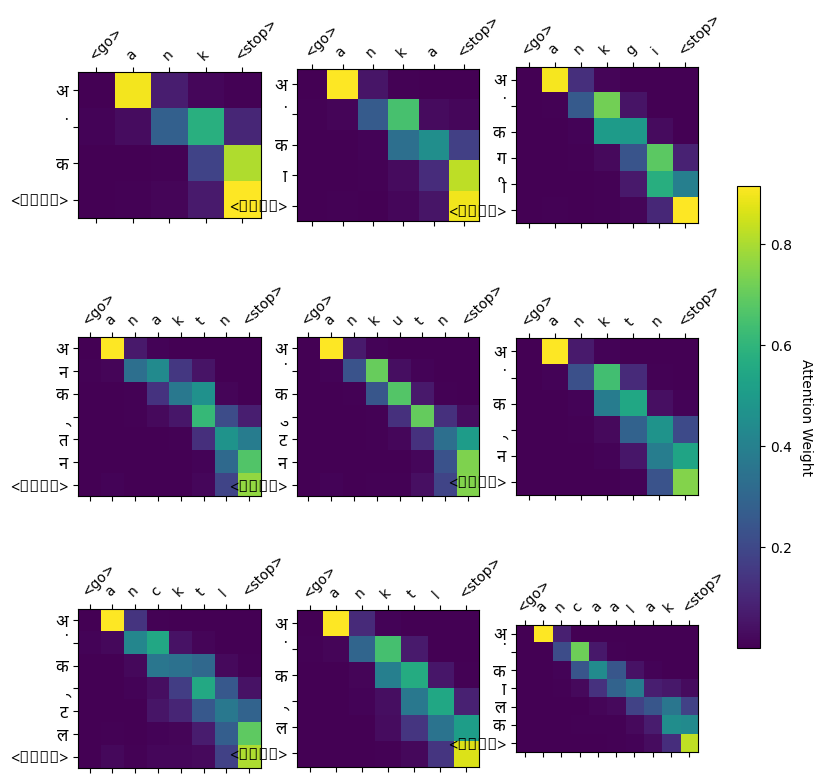

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
import urllib.request
import os
import torch

# Download Noto Sans Devanagari font if not present
font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf'
font_path = 'NotoSansDevanagari-Regular.ttf'
if not os.path.exists(font_path):
    urllib.request.urlretrieve(font_url, font_path)

hindi_font = FontProperties(fname=font_path)

# Load model and data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = best_model
model.to(device)
model.eval()

# Get real attention data
_, _, test_loader, src_vocab, trg_vocab = get_dataloaders(batch_size=9)
attentions, src_tokens, trg_tokens = get_model_attention_data(
    model, test_loader, src_vocab, trg_vocab, device, num_examples=9
)

# Plot 3x3 grid of attention heatmaps
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    if i >= len(attentions):
        ax.axis('off')
        continue
        
    attn = attentions[i]
    src = src_tokens[i]
    trg = trg_tokens[i]
    
    # Create heatmap
    im = ax.matshow(attn, cmap='viridis')
    ax.set_xticks(np.arange(len(src)))
    ax.set_yticks(np.arange(len(trg)))
    ax.set_xticklabels(src, fontsize=10)
    ax.set_yticklabels(trg, fontproperties=hindi_font, fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
    
    # Add source and target word labels
    src_word = ''.join(src)
    trg_word = ''.join(trg)
    #ax.set_title(f'{src_word} → {trg_word}', fontproperties=hindi_font, fontsize=14)

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.set_label('Attention Weight', rotation=270, labelpad=15)

#plt.tight_layout()
plt.savefig('attention_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
